# Weather sub-sampling

This project uses data from UKCP09. The data is provided as 1000 sequences each of hourly (and daily) data for 30 years. For each sequence there is a control (cntr) and scenario (scen) sequence. The control sequence excludes any climate change effects, while the scenario sequence includes climate change impacts.

The purpose of this notebook is to undertake some sub-sampling of the 1000 sequences to reduce the data set for robust optimisation and simulation.

In [1]:
import numpy as np
import pandas
import os
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
JSON_DIR = 'json'
DATA_DIR = 'data'
WEATHER = os.path.join(DATA_DIR, 'ukcp09_full.h5')
OUTPUT_PATH = 'outputs'
FIG_PATH = os.path.join(OUTPUT_PATH, 'figures')

In [3]:

rainfall = {}
sunshine = {}

with pandas.HDFStore(WEATHER, mode='r') as store:
        f = IntProgress(min=0, max=len(store.keys())) # instantiate the bar
        display(f) # display the bar
    
        f.value = 0
        for i, key in enumerate(store.keys()):            
            f.value = i
            
            if 'hly' in key:
                continue  # Skip hourly data
                
            if 'scen' not in key:
                continue

            df = store[key]

            # Massage the dates into a timeseries index.
            # NOTE: UKCP09 uses notional years starting in 3000.
            # pandas doesn't like dates this far in the future say we move them to 2000
            dates = {k: df.index.get_level_values(k) for k in ('year', 'month', 'day')}
            dates['year'] = dates['year'] - 1000
            dates = pandas.to_datetime(dates)
            df.index = dates

            # Total annual rainfall & sunshine hours
            rainfall[key] = df['precip_dtotal'].resample('A').sum()
            sunshine[key] = df['sunshine_dtotal'].resample('A').sum()      

        
rainfall = pandas.DataFrame(rainfall)
sunshine = pandas.DataFrame(sunshine)

IntProgress(value=0, max=2000)

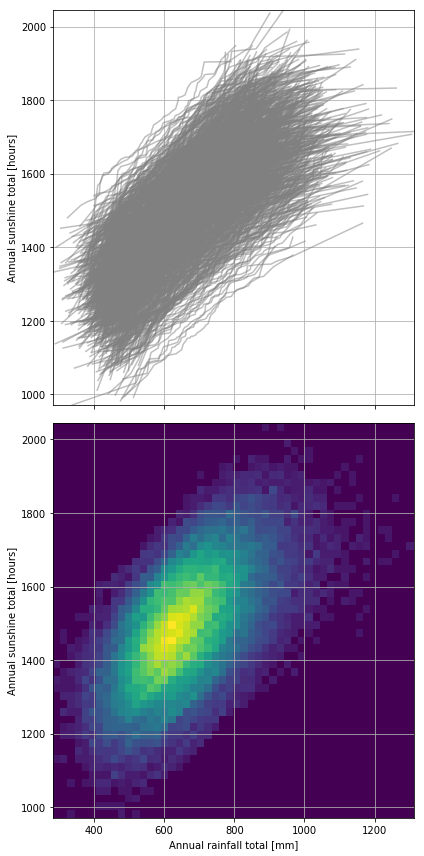

In [4]:

q = np.linspace(0, 1)

rainfall_quant = rainfall.quantile(q)
sunshine_quant = sunshine.quantile(q)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 12), sharey=True, sharex=True)

ax1.plot(rainfall_quant, sunshine_quant, color='grey', alpha=0.5)
ax1.grid();
#ax1.set_xlabel('Annual rainfall total [mm]')
ax1.set_ylabel('Annual sunshine total [hours]')

gamma = 0.5
ax2.hist2d(rainfall_quant.values.flatten(), sunshine_quant.values.flatten(),bins=50, norm=mcolors.PowerNorm(gamma),)
ax2.grid()
ax2.set_xlabel('Annual rainfall total [mm]')
ax2.set_ylabel('Annual sunshine total [hours]')
plt.tight_layout()
fig.savefig(os.path.join(FIG_PATH, 'Weather - QQ & Hist2d.png'))


## Selection of sub-sampling

Here we implement a sub-sample selection algorithm. The algorithm uses a Monte Carlo process to select sub-samples of a chosen size. The Monte Carlo selection with the best square-root sum of squares (SQSS) is chosen. The Monte Carlo process is then run for multiple sub-sample sizes. 

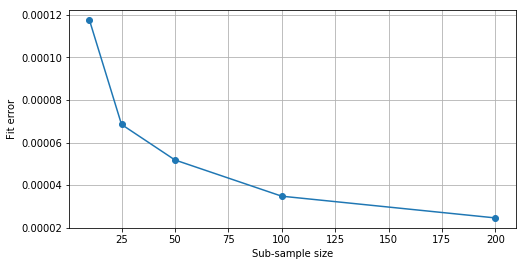

In [52]:

Hfull, xedges, yedges = np.histogram2d(rainfall_quant.values.flatten(), 
                                   sunshine_quant.values.flatten(),
                                   bins=50,density=True)


def find_sample(size, tries=10):
    
    best_fit = np.inf
    best_indices = None
    for i in range(tries):
        
        sample_indices = sorted(np.random.choice(rainfall_quant.shape[1], size=size))
        assert len(sample_indices) == size
        rainfall_sample = rainfall_quant.iloc[:, sample_indices]
        sunshine_sample = sunshine_quant.iloc[:, sample_indices]

        H, _, _ = np.histogram2d(rainfall_sample.values.flatten(), 
                                           sunshine_sample.values.flatten(),
                                           bins=(xedges, yedges), density=True)

        fit = np.sqrt(np.sum((H-Hfull)**2))
        
        if fit < best_fit:
            best_fit = fit
            best_indices = sample_indices
            
    return best_indices, best_fit

        
sample_sizes = (10, 25, 50, 100, 200)
sample_indices = {}
sample_fit = []

for size in sample_sizes:
    indices, fit = find_sample(size, tries=200)
    sample_indices[size] = indices
    
    sample_fit.append(fit)
    
    
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(sample_sizes, sample_fit, '-o')
ax.grid()
ax.set_xlabel('Sub-sample size')
ax.set_ylabel('Fit error');




### Save the sub-sampled results

In [53]:

for size, indices in sample_indices.items():
    rainfall_sample = rainfall.iloc[:, indices]
        
    out = WEATHER.replace('_full.h5', f'_sub{size:03d}.h5')
    print(f'Writing sub-sampled of size {size} output to: {out}')
    with pandas.HDFStore(WEATHER, mode='r') as in_store, \
        pandas.HDFStore(out, mode='w', complib='zlib', complevel=9) as out_store:
        
        for c in rainfall_sample.columns:
            out_store[c] = in_store[c]
            # Also copy the cntr data
            c_cntr = c.replace('scen', 'cntr')
            out_store[c_cntr] = in_store[c_cntr]
    

Writing sub-sampled of size 10 output to: data/ukcp09_sub010.h5
Writing sub-sampled of size 25 output to: data/ukcp09_sub025.h5
Writing sub-sampled of size 50 output to: data/ukcp09_sub050.h5
Writing sub-sampled of size 100 output to: data/ukcp09_sub100.h5
Writing sub-sampled of size 200 output to: data/ukcp09_sub200.h5
